In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from numba import njit
from time import sleep

from IPython.display import HTML
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable

#np.random.seed(19680801)

In [2]:
def trunc_gaussian(mu, sigma, plot = False):
    mean = mu
    std = sigma
    # Limits of truncation
    myclip_a = 0
    myclip_b = 1
    
    a, b = (myclip_a - mean) / std, (myclip_b - mean) / std
    if plot:
        x_range = np.linspace(-1,2,1000)
        plt.plot(x_range, truncnorm.pdf(x_range, a, b, loc = mean, scale = std))

    return truncnorm.rvs(a, b, loc = mean, scale = std)

@njit
def trunc_gaussian_jit_sample(mu, sigma):
    sample = -1
    while sample < 0 or sample > 1:
        sample = np.random.normal(mu, sigma)
    return sample    

@njit
def truncated_gaussian_jit(mu, sigma, size):
    samples = np.zeros(size, dtype=np.float32)
    for i in range(size):
        samples[i] = trunc_gaussian_jit_sample(mu, sigma)
        
    return samples

def test_truncated_normal(sigma):
    mean = 0.5
    std = sigma
    
    # Limits of truncation
    myclip_a = 0
    myclip_b = 1
    a, b = (myclip_a - mean) / std, (myclip_b - mean) / std    
    
    samples = truncated_gaussian_jit(mean, sigma, 1000000)
    n, x, _ = plt.hist(samples, bins=100, density=True)
    #plt.xlim((-0.1,1.1))
    plt.plot(x, truncnorm.pdf(x, a, b, loc = mean, scale = std)) 
    
    plt.show()


@njit
def autocorrelation(System, SystemSnapshot):
    Ly, Lx = System.shape
    Ly0,Lx0 = SystemSnapshot.shape
    
    if Ly0 != Ly or Lx0 != Lx:
        raise ValueError("Shape of System and SystemSnapshot is not equal")
    
    size = Lx * Ly    
    DensityParticles = np.sum(System) / size
    
    Sum = 0
    for i in range(Ly):
        for j in range(Lx):
            Sum += System[i][j] * SystemSnapshot[i][j]
    Corr = (Sum / size) - (DensityParticles)**2 # 0.25 is the density of particles^2
    
    return Corr

@njit
def checkboard(mu, sigma): # Filling the lattice (Lx*Ly) with particles alternatively (chess fashion)    
    System = np.zeros((Ly, Lx), dtype=np.float32)  # Ly vectors with Lx (zero) components 

    System[::2, ::2] = 1  # Set even rows and even columns to 1
    System[1::2, 1::2] = 1  # Set odd rows and odd columns to 1

    JumpRateGrid = np.ones((Ly,Lx))*(-0.1)
    for i in range(Ly):
        for j in range(Lx):
            if System[i][j] == 1:
                # JumpRateGrid[i][j] = trunc_gaussian_jit_sample(mu, sigma)
                
                #Build-in method
                #JumpRateGrid[i][j] = trunc_gaussian(mu, sigma)

                # Old method
                JumpRateGrid[i][j] = np.random.normal(mu, sigma)                
                #Limiting its values to [0,1]
                if JumpRateGrid[i][j] > 1:
                    JumpRateGrid[i][j] = 1
                elif JumpRateGrid[i][j] < 0:
                    JumpRateGrid[i][j] = 0
                    
    return System, JumpRateGrid

@njit
def random_system(n, mu, sigma): # Filling the lattice (Lx*Ly) randomly with n particles
    assert n <= (Lx*Ly)     
    System = np.concatenate((np.ones(n, dtype=np.float32), np.zeros(Lx*Ly-n, dtype=np.float32))) 
    np.random.shuffle(System)
    System = System.reshape((Ly, Lx))
    
    JumpRateGrid = np.ones((Ly,Lx), dtype=np.float32)*(-0.1)
    for i in range(Ly):
        for j in range(Lx):
            if System[i][j] == 1:
                JumpRateGrid[i][j] = trunc_gaussian_jit_sample(mu, sigma) # probability of jumping forward or transversally
                
                #Build-in method
                #JumpRateGrid[i][j] = trunc_gaussian(mu, sigma)                
                
                # Old method                
                # JumpRateGrid[i][j] = np.random.normal(mu, sigma)                
                # # Limiting its values to [0,1]
                # if JumpRateGrid[i][j] > 1:
                #     JumpRateGrid[i][j] = 1
                # elif JumpRateGrid[i][j] < 0:
                #     JumpRateGrid[i][j] = 0                

    return System, JumpRateGrid 

In [3]:
@njit
def Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma):
 # Check utilities
    print_stuff = 0 #0 do not print; 1 print basics; 2 print details; for unit tests
    if print_stuff == 2 and totalMCS > 10:
        raise ValueError("totalMCS too big to print everything")
    SystemCheckboard = np.zeros((Ly, Lx), dtype=np.float32)  # Ly vectors with Lx (zero) components 
    SystemCheckboard[::2, ::2] = 1  # Set even rows and even columns to 1
    SystemCheckboard[1::2, 1::2] = 1  # Set odd rows and odd columns to 1
    
 # Memory allocation                   
    DensityParticlesTot = np.zeros(totalMCS, dtype=np.float32) 
    CorrTot = np.zeros(totalMCS, dtype=np.float32) 
    CurrentAlongTot = np.zeros(totalMCS, dtype=np.float32)  # totalMCS vectors with Ly (zero) components 
    CurrentTransvTot = np.zeros(totalMCS, dtype=np.float32)  # totalMCS vectors with Ly (zero) components
    OccupationGridTot = np.zeros((Ly, Lx), dtype=np.float32)

 #Beginning of the simulation
    for iwalk in range(runsNumber):
       # Initialize system
        if init == "chess":  # Filling the lattice with particles alternatively (chess fashion)
            System, JumpRateGrid = checkboard(mu, sigma)
        elif init == "random": # Filling the lattice with N particles randomly
            System, JumpRateGrid = random_system(N, mu, sigma)
        
       # Mapping System at t=0
        SystemSnapshot = System.copy()
        if init == "chess" and print_stuff > 0: 
            if (SystemSnapshot != SystemCheckboard).all(): raise ValueError("System at t=0, not in checkboard mode")        

       # Frames for the animation
         # Frames of the location of particles
        System_movie = np.zeros((N+1, Ly, Lx), dtype=np.float32)
        System_movie[0] = SystemSnapshot

         # Frames of each movement in one MCS
        JumpRate_movie = np.zeros(((totalMCS*N)+1, Ly, Lx), dtype=np.float32)
        JumpRate_movie[0] = JumpRateGrid

         # Frames of set of movements after one MCS   
        JumpRate_short_movie = np.zeros((totalMCS+1, Ly, Lx), dtype=np.float32)
        JumpRate_short_movie[0] = JumpRateGrid 

       # Memory allocation                   
        Corr = np.zeros(totalMCS, dtype=np.float32)
        DensityParticles = np.zeros(totalMCS, dtype=np.float32) 
        OccupationGrid = np.zeros((Ly, Lx), dtype=np.float32)
        CurrentAlong = np.zeros(totalMCS, dtype=np.float32) 
        CurrentTransv = np.zeros(totalMCS, dtype=np.float32)

       # Beginning of a single run
        for istep in range(totalMCS):
            if print_stuff == 2: print("MonteCarlo iteration:", istep)

            Along_count = 0
            Transv_count = 0

            # Computes correlation function; CorrFunction[0] = 0.25 by definition 
            Corr[istep] += autocorrelation(System, SystemSnapshot)
            if init == "chess" and Corr[0] != 0.25:
                raise ValueError("Initial correlation at the checkboard distribution is not 0.25")

            for moveAttempt in range(N): # To make a move over all particles
                while True:
                    dice = random.randint(0, Lx * Ly - 1)  # Picks the random lattice site in the array
                    X = dice // Lx
                    Y = dice - X * Lx

                    """ 
                    The lattice is labelled from the left top to the right 
                     as Z= 0, 1, 2    or    [X,Y]= (0,0), (0,1), (0,2) 
                           3, 4, 5                 (1,0), (1,1), (1,2)
                    """

                    if System[X][Y] == 1: # The lattice has to be occupied

                        JumpRate = JumpRateGrid[X][Y] # probability of jumping forward or transversally
                        dice = random.random() 
                        if print_stuff == 2: print("* Particle at (%s, %s) move attempt:"% (X,Y))

                        if dice < JumpRate:
                            JumpAlong = random.randint(0, 1) # 0.5 prob of jumping forward or not jumping
                            JumpTransverse = 2 # No jump up or down
                            if print_stuff == 2: print("   Tries to jump along: dice = %s < Jumprate = %s:"% (dice, JumpRate))

                        else:
                            JumpAlong = 2 # No jump backwards
                            JumpTransverse = random.randint(0, 1) # 0.5 prob of jumping up or down
                            if print_stuff == 2: print("   Tries to jump transversally: dice = %s > Jumprate = %s"% (dice, JumpRate))


                        # Updating the system
                        # Simple implementation of Periodic boundary conditions
                        xPrev = Ly - 1 if X == 0 else X - 1        
                        xNext = 0 if X == Ly - 1 else X + 1
                        yNext = 0 if Y == Lx - 1 else Y + 1


                        if JumpAlong == 0:             # hop forward
                            if System[X][yNext] == 0:  # if next site is free
                                temp = System[X][Y]
                                System[X][Y] = System[X][yNext]
                                System[X][yNext] = temp

                                temp2 = JumpRateGrid[X][Y]
                                JumpRateGrid[X][Y] = JumpRateGrid[X][yNext]
                                JumpRateGrid[X][yNext] = temp2

                                Along_count += 1

                                if print_stuff == 2: print("   Particle at (%s, %s) hops forward" % (X, Y))
                            else:
                                if print_stuff == 2: print("   Particle at (%s, %s) can't jump due an obstacle" % (X, Y))

                        if JumpTransverse == 0: # hop up
                            if System[xPrev][Y] == 0: 
                                temp = System[X][Y]
                                System[X][Y] = System[xPrev][Y]
                                System[xPrev][Y] = temp

                                temp2 = JumpRateGrid[X][Y]
                                JumpRateGrid[X][Y] = JumpRateGrid[xPrev][Y]
                                JumpRateGrid[xPrev][Y] = temp2

                                Transv_count += 1

                                if print_stuff == 2: print("   Particle at (%s, %s) hops up" % (X, Y))
                            else:
                                if print_stuff == 2: print("   Particle at (%s, %s) can't jump due an obstacle" % (X, Y))

                        if JumpTransverse == 1: # hop down
                            if System[xNext][Y] == 0: 
                                temp = System[X][Y]
                                System[X][Y] = System[xNext][Y]
                                System[xNext][Y] = temp

                                temp2 = JumpRateGrid[X][Y]
                                JumpRateGrid[X][Y] = JumpRateGrid[xNext][Y]
                                JumpRateGrid[xNext][Y] = temp2

                                Transv_count -= 1

                                if print_stuff == 2: print("   Particle at (%s, %s) hops down" % (X, Y))
                            else:
                                if print_stuff == 2: print("   Particle at (%s, %s) can't jump due an obstacle" % (X, Y))

                        # Frames for the movie
                        System_movie[moveAttempt+1] = System
                        JumpRate_movie[(istep*N)+moveAttempt+1] = JumpRateGrid

                        break  # Exit the loop

            # Frames for the movie at the last MCS
            JumpRate_short_movie[istep+1] = JumpRateGrid

            # Computes currents
            CurrentAlong[istep] = Along_count / N # Sum of the current along Lx
            CurrentTransv[istep] = Transv_count / N # Sum of the current along Ly

            # Computes the total number of particles
            DensityParticles[istep] = np.sum(System) / size

            if DensityParticles[istep] != 0.5:
                raise ValueError("The density of particles does not conserve")

            # To compute occupation probability
            OccupationGrid += System


        # Computing parameters after a single run
        OccupationGrid /= totalMCS
        OccupationGridTot += OccupationGrid

        for dt in range(totalMCS):
            CorrTot[dt] += Corr[dt]
            DensityParticlesTot[dt] += DensityParticles[dt] 
            CurrentAlongTot[dt] += CurrentAlong[dt]
            CurrentTransvTot[dt] += CurrentTransv[dt]


        if print_stuff == 1 or print_stuff == 2: print("Runs done:", iwalk+1)


    # Simulation results output
    for dt in range(totalMCS):
        CorrTot[dt] /= runsNumber
        DensityParticlesTot[dt] /= (runsNumber)
        CurrentAlongTot[dt] /= (runsNumber)
        CurrentTransvTot[dt] /= (runsNumber)

    # Occupation probability along the X axis
    OccupationGridTot /= runsNumber
    HorizontalOccupProb = OccupationGridTot.sum(axis=0)/Ly


    #print('Finished!')
    #print(f"Run number: {iwalk}/{runsNumber}\r")
    
    return DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie

In [4]:
def density_particles(sigma):
    DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)    
    x_axis=np.array(range(totalMCS))
    plt.plot(x_axis[5:], DensityParticlesTot[5:], color='blue')
    
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")    
    plt.xlabel('Time')
    plt.ylabel('Density of Particles')
#     stats = ('Initial cond. = %s \n'
#              f'MCS = %i \n'
#              f'(Lx, Ly) = %(i,i) \n'
#              f'$\\mu$ = {mu:.2f}'% (init, totalMCS, (Lx, Ly)))

#     plt.text(totalMCS/5, 0.515, stats , fontsize=12, ha="center", va="center",
#              bbox=dict(boxstyle="square",color= 'lightskyblue'
#                       ))
    plt.grid(True) 
    #plt.savefig('Random_sigma=0,3 - Density.pdf')

In [5]:
def density_particles(sigma):
    DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)    
    x_axis=np.array(range(totalMCS))
    plt.plot(x_axis[5:], DensityParticlesTot[5:], color='blue')
    
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")    
    plt.xlabel('Time')
    plt.ylabel('Density of Particles')
#     stats = ('Initial cond. = %s \n'
#              f'MCS = %i \n'
#              f'(Lx, Ly) = %(i,i) \n'
#              f'$\\mu$ = {mu:.2f}'% (init, totalMCS, (Lx, Ly)))

#     plt.text(totalMCS/5, 0.515, stats , fontsize=12, ha="center", va="center",
#              bbox=dict(boxstyle="square",color= 'lightskyblue'
#                       ))
    plt.grid(True) 
    #plt.savefig('Random_sigma=0,3 - Density.pdf')

In [6]:
def autocorrelation_plot(sigma):
    DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)    
    x_axis=np.array(range(1,totalMCS+1))
    f=1/x_axis
    f2 = 0.1*x_axis**(-1.1)
    plt.plot(x_axis[5:], f2[5:], color='black', label = 'Out of the steady state')
    plt.plot(x_axis[5:], CorrTot[5:], '.', color='coral', label = 'Samples')
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")
    plt.xlabel('Time (log scale)')
    plt.ylabel('Autocorrelation Function (log scale)')
    plt.legend()
    # stats = ('Initial cond. = %s \n'
    #              f'MCS = %i \n'
    #              f'$\\mu$ = {mu:.2f}\n'
    #              f'$\\sigma$ = {sigma:.2f}'% (init, totalMCS))
    # plt.text(10, 0.00009, stats , fontsize=12, ha="center", va="center",
    #          bbox=dict(boxstyle="square",color= 'lightskyblue'
    #                  ))

    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True)

    #plt.savefig('Random_sigma=0,01 - Autocorrelation')

In [7]:
def occup_prob(sigma):
    x_axis=np.array(range(Lx))
    DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)    

    plt.plot(x_axis, HorizontalOccupProb, '.')
    
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")
    plt.xlabel('Horizontal length')
    plt.ylabel('Occupation probability')
    plt.ylim([0.4,0.6])
    plt.grid(True)

    # stats = ('Initial cond. = %s \n'
    #              f'MCS = %i \n'
    #              f'$\\mu$ = {mu:.2f}\n'
    #              f'$\\sigma$ = {sigma:.2f}'% (init, totalMCS))
    # plt.text(Lx-10, 0.55, stats , fontsize=12, ha="center", va="center",
    #          bbox=dict(boxstyle="square",color= 'lightskyblue'))

    #plt.savefig('Random_sigma=0,01 - Occupation probability.pdf')
    

In [13]:
def current_plot(sigma):
    plt.cla()
    x_axis=np.array(range(totalMCS))
    DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)    

    #The steady current of particle J, through a bond i, i+1 is given by the rate r multiplied by the probability that there is a particle at site i, and site i+1 is vacant
    r = 0.5 #jumping rate
    p = 0.5 #probability forward
    prob_occ=1 # we make a transition only when the site chosen is occupied
    prob_vac=1/2 #density of particles in the system

    f = np.array([r*p*prob_occ*prob_vac]*totalMCS)
    sigma = fixed_sigma
    plt.plot(x_axis[5:], CurrentAlongTot[5:], '.', label='Parallel Current')
    plt.plot(x_axis[5:], CurrentTransvTot[5:], '.', label='Perpendicular Current')
    plt.plot(x_axis, f, label='Parallel Current for p=1/2', color = 'red')

    plt.xlabel('Time')
    plt.ylabel(f'Current. {N} moves averaged')
    plt.legend(loc = 'center right')


    plt.grid(True)

    #plt.savefig('Random_sigma=0,01 -  Currents.pdf')


In [14]:
# Current comparison
def currents_sigmas():
    
   # Plot
    plt.cla()
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")
    plt.xlabel('Time')
    plt.ylabel(f'Current. {N} moves averaged')
    plt.grid(True)

    # stats = ('Initial cond. = %s \n'
    #      f'(Lx, Ly) = (%i, %i) \n'
    #      f'Gaussian dist. mean, $\\mu$ = {mu:.2f}'% (init, Lx, Ly))
    # plt.text(totalMCS/5, 0.32, stats , fontsize=11, ha="left", va="center",
    #          bbox=dict(boxstyle="square",color= 'lightskyblue'))
    # plt.rcParams['text.usetex'] = True
    
    for sigma in [0.0001, 0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 5.0]:
    #for sigma in [0.0001, 0.1, 0.6, 5.0]:        
        DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)
        times = np.array(range(totalMCS))     
        plt.plot(times, CurrentAlongTot, label=f"$\\sigma = {sigma}$")
        
    plt.legend()
    #plt.savefig('Pictures/Current_Different_Sigmas/Currents.pdf')    

In [15]:
#@njit
def average_run_current(sigmas):
    
    currents = np.zeros(sigmas.shape[0], dtype = np.float32)    
    i = 0
    for sigma in sigmas:
        DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, sigma)
        currents[i] = np.mean(CurrentAlongTot)
        i += 1
        sleep(0.1) # to avoid #IOStream.flush timed out
        print(i)
    return currents

def average_run_current_over_sigmas():
   # Plot
    plt.cla()
    plt.xlabel('Standard Deviation, $\\sigma$ (log scale)')
    plt.xscale('log')
    plt.ylabel(f'Current. {N} moves averaged')
    plt.title(f"TASEP. Gaussian jumping rate over {runsNumber} runs")
    plt.grid(True)

#    stats = ('Initial cond. = %s \n'
#         f'(Lx, Ly) = (%i, %i) \n'
#         f'Gaussian dist. mean, $\\mu$ = {mu:.2f}'% (init, Lx, Ly))
#    plt.text(totalMCS/5, 0.32, stats , fontsize=11, ha="left", va="center", bbox=dict(boxstyle="square",color= 'lightskyblue'))
    plt.rcParams['text.usetex'] = True        
    
    sigmas = np.logspace(-4, 1, 150, dtype=np.float32)        
    currents = average_run_current(sigmas)
    plt.plot(sigmas, currents)
    #plt.savefig('Pictures/Current_Different_Sigmas/AverageCurrentVsSigma.pdf')    

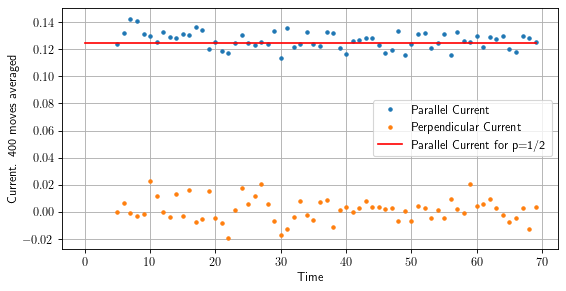

In [16]:
if __name__ == '__main__':
    # Simulation parameters
    runsNumber = 10
    totalMCS = 70 #Total number of Monte Carlo steps per single run
    Lx = 40 # Number of columns, length
    Ly = 20 # Number of rows, height
    init = "chess"
    mu = 0.5
    fixed_sigma = 0.01
    
    N = Lx * Ly // 2
    size = Lx * Ly

    plt.rcParams["figure.figsize"] = (8, 4)
    plt.rcParams["figure.dpi"] = 80
    plt.rcParams["font.size"] = 11

   # Fixed sigma plots
    #density_particles(fixed_sigma)
    #autocorrelation_plot(fixed_sigma)
    #occup_prob(fixed_sigma)
    current_plot(fixed_sigma)
    
   # Different sigmas plots
    #currents_sigmas()
    #verage_run_current_over_sigmas()
    
    #DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, fixed_sigma)    
    

In [12]:
# MOVIE
# Simulation parameters
runsNumber = 1
totalMCS = 400 #Total number of Monte Carlo steps per single run
Lx = 40 # Number of columns, length
Ly = 20 # Number of rows, height
init = "chess"
mu = 0.5
fixed_sigma = 0.3

N = Lx * Ly // 2
size = Lx * Ly

# Movie of each MCS at the last run
DensityParticlesTot, CorrTot, CurrentAlongTot, CurrentTransvTot, HorizontalOccupProb, JumpRate_movie, JumpRate_short_movie = Simulate(runsNumber, totalMCS, Lx, Ly, init, mu, fixed_sigma)

fig = plt.figure()
ax = fig.add_subplot(111)
#fig.patch.set_facecolor('grey') #Change background color

# To position colorbars 
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

cv0 = JumpRate_short_movie[0]
im = ax.imshow(cv0, cmap = "gnuplot")
cb = fig.colorbar(im, cax=cax)

#tx1 = fig.annotate('MC 1', xy=(0,-0))
tx2 = ax.set_title('Frame 0 after one MCS of the last run', y=1)

axoff = ax.axis('off')
plt.close() # To not have the plot of frame 0 


def animate(frame):
    arr = JumpRate_short_movie[frame]
    vmax     = 1
    vmin     = np.min(arr)
    im.set_data(arr)
    im.set_clim(vmin, vmax)
    cb.ax.set_ylabel('Jumping Rate')
    #tx1.set_text('MC 1')
    tx2.set_text('Frame {0}'.format(frame))
    # The colorbar updates itself when the mappable it watches (im) changes

#ani = FuncAnimation(fig, animate, frames=len(System_movie), repeat=False)
ani = FuncAnimation(fig, animate, frames=len(JumpRate_short_movie), repeat=False)
HTML(ani.to_jshtml())

ani.save('Pictures/animation_checkboard.mp4')
# #plt.show()